In [4]:
from Helper_functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers

Using TensorFlow backend.


# Helper

In [5]:
def train(measure,units,layerz,shape,num,split):
    train_label = measure[0:split]
    test_label = measure[split:]

    model = build_model_R(units,layerz,"mae",shape)
    
    #model = build_model_Special("mae",shape)
    
    history = model.fit(
        train_data,train_label, epochs = num, batch_size = 100 ,validation_data = (test_data,test_label), verbose = 0 )

    print("minimum Training MAE: ", np.min(history.history['mean_absolute_error']))
    print("at: ", np.argmin(history.history['mean_absolute_error']))
    print("minimum Validation MAE: ", np.min(history.history['val_mean_absolute_error']))
    print("at: ", np.argmin(history.history['val_mean_absolute_error']))
    return model,history

def build_model_R(units,layerz,metric,shape,lozz= 'logcosh'):
    model = models.Sequential()
    model.add(layers.Dense(units, activation = 'relu', 
                           input_shape = (shape,)))
    for layer in range(layerz):
        model.add(layers.Dropout(0.4))
        model.add(layers.Dense(units, activation = 'relu'))
    model.add(layers.Dense(1)) #linear layer
    model.compile(optimizer = 'rmsprop', loss = lozz, metrics =[metric] )
    return model


def build_model_Special(metric,shape,lozz= 'logcosh'):
    model = models.Sequential()
    model.add(layers.Dense(units, activation = 'relu', 
                           input_shape = (shape,)))
    
    model.add(layers.Dense(100, activation = 'relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(90, activation = 'relu'))  
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(80, activation = 'relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(70, activation = 'relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(50, activation = 'relu'))
    model.add(layers.Dense(30, activation = 'relu'))
    model.add(layers.Dense(40, activation = 'relu'))
    model.add(layers.Dense(50, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss = lozz, metrics =[metric] )
    return model

def smooth_points(histories, factor=0.9):
    
    smoothed_points1 = []
    smoothed_points2 = []
    points = zip(histories['val_mean_absolute_error'],histories['mean_absolute_error'])
    
    for point1,point2 in  points:
        if smoothed_points1:
            previous = smoothed_points1[-1]
            smoothed_points1.append(previous * factor + point1*(1 - factor))
            previous = smoothed_points2[-1]
            smoothed_points2.append(previous * factor + point2*(1 - factor))
        else:
            smoothed_points1.append(point1)
            smoothed_points2.append(point2)
            
    smooth_histories = dict(
                            val_mean_absolute_error = smoothed_points1,
                            mean_absolute_error = smoothed_points2
                            )
    return smooth_histories


def plot(histories):
    epoch = range(1,len(histories['val_mean_absolute_error'])+1)[10:]
    f, axes = plt.subplots(1, 2, figsize=(12,12))
    axes = axes.reshape((2,))
  
    axes[0].plot(epoch,histories['val_mean_absolute_error'][10:], label='Training')
    axes[1].plot(epoch,histories['mean_absolute_error'][10:], 'r', label='Validation')
    axes[1].legend()
    axes[0].set_xlabel("Epoch")
    axes[1].set_xlabel("Epoch")
    axes[0].set_ylabel("MAE")

    axes[1].set_ylabel("Loss")
    
def preprocess(path,ratio):    
    pair_df = pd.read_csv(path)
    data = pair_df.loc[:,"inter1_x":"liked"].values.astype("float")
    labels = pair_df.loc[:,"liked":].values.astype("float")
    
    # randomize data and label set
    sample_size = data.shape[0]
    arr = np.arange(sample_size)
    data = data[arr].reshape(data.shape)
    labels = labels[arr].reshape(labels.shape)
    
    dependent_measures = dict(
    liked = labels[:,0], sexatt = labels[:,1], likyes = labels[:,2],
    fliked = labels[:,3], fsexatt = labels[:,4] , flikyes = labels[:,5],
    saidyes = labels[:,6], fsaidyes = labels[:,6], match = labels[:,7]
    )

    # partition train and test 
                                    # NOTE: may need to shuffle them
    split = int(ratio * data.shape[0])
    train_data = data[0:split]
    test_data = data[split:]

    # normalize
    mean = train_data.mean(axis = 0)
    std = train_data.std(axis = 0)

    train_data -= mean
    train_data /= std

    test_data -= mean
    test_data /= std
    
    return train_data,test_data, dependent_measures,split
    

# Preprocessing

In [3]:
path, ratio = "./pair1Dataframe.csv", 0.8
train_data, test_data, dependent_measures,split  = preprocess(path,ratio)

# Benchmark (random)

In [ ]:
#dependent_measures["FLikYes"]
random_predict = np.random.randint(1,10, size= (train_data.shape[0]) )

In [5]:
measures = ['liked', 'sexatt', "likyes", 'fliked', 'fsexatt', "flikyes"]
for measure in measures:
    score = ( dependent_measures[measure][0:split].astype('int64') == np.mean(dependent_measures[measure][0:split]).astype('int64')).sum()/train_data.shape[0]
    print(measure,score)

liked 0.16707317073170733
sexatt 0.1274390243902439
likyes 0.0975609756097561
fliked 0.14634146341463414
fsexatt 0.1048780487804878
flikyes 0.0676829268292683


# Type 1

## Training (using Regression)

### Males

In [3]:
units,layerz,shape, num = 64,3, train_data.shape[1] , 10000
liked_model_R,history = train(dependent_measures["liked"],units,layerz,shape,num,split)
plot(history.history)

NameError: name 'train_data' is not defined

In [ ]:
units,layerz,shape,num = 64,3, train_data.shape[1],10000 
likyes_model_R,likyes_history  = train(dependent_measures["LikYes"],units,layerz,shape,num)

#plot(smooth_points(history.history))
plot(likyes_history.history)

In [ ]:
units,layerz,shape,num = 64,3, train_data.shape[1], 15000 
sexatt_model_R,history  = train(dependent_measures["SexAtt"],units,layerz,shape,num)

#plot(smooth_points(history.history))
plot(history.history)

### Females

In [ ]:
units,layerz,shape, num = 64,3, train_data.shape[1] , 10000
fliked_model_R,history = train(dependent_measures["FLiked"],units,layerz,shape,num)
plot(history.history)

In [ ]:
units,layerz,shape,num = 64,3, train_data.shape[1],10000 
flikyes_model_R,flikyes_history  = train(dependent_measures["FLikYes"],units,layerz,shape,num)

#plot(smooth_points(history.history))
plot(flikyes_history.history)

In [ ]:
units,layerz,shape,num = 64,3, train_data.shape[1],10000 
fsexatt_model_R,fsexatt_history  = train(dependent_measures["FSexAtt"],units,layerz,shape,num)

#plot(smooth_points(history.history))
plot(fsexatt_history.history)

# Type 2

## Training (using Regression)

In [6]:
path, ratio = "./pair2Dataframe.csv", 0.8
train_data, test_data, dependent_measures,split  = preprocess(path,ratio)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
minimum Training MAE:  0.07929073687551952
at:  12697
minimum Validation MAE:  0.1635148030955617
at:  18101


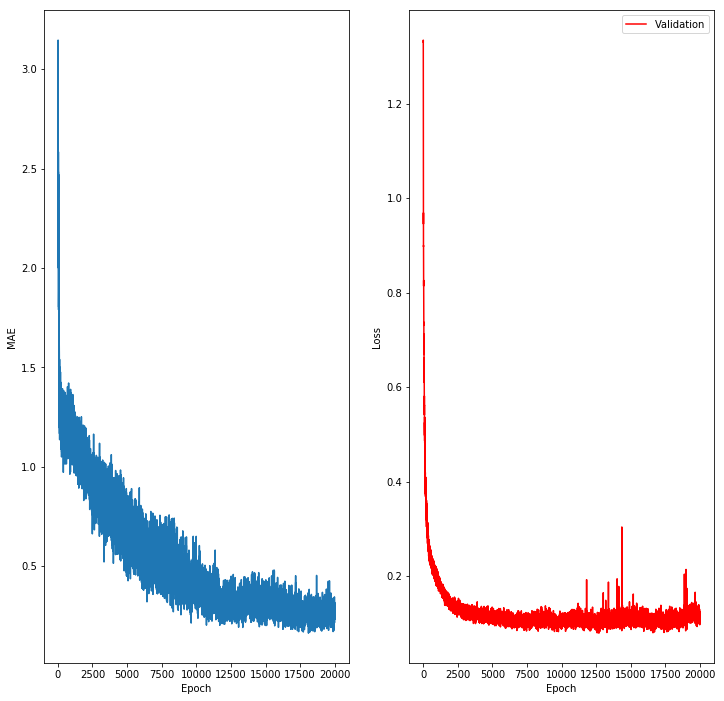

In [7]:
units,layerz,shape, num = 64,5, train_data.shape[1] , 20000
liked_model_R,history = train(dependent_measures["liked"],units,layerz,shape,num,split)
plot(history.history)

In [ ]:
units,layerz,shape,num = 64,5, train_data.shape[1],20000 
likyes_model_R,likyes_history  = train(dependent_measures["likyes"],units,layerz,shape,num,split)
#plot(smooth_points(history.history))
plot(likyes_history.history)

In [ ]:
units,layerz,shape,num = 100,3, train_data.shape[1], 25000 
sexatt_model_R,history  = train(dependent_measures["sexatt"],units,layerz,shape,num,split)

#plot(smooth_points(history.history))
plot(history.history)

### Females

minimum Training MAE:  0.3431685686838336
at:  5267
minimum Validation MAE:  1.4604238358939565
at:  225


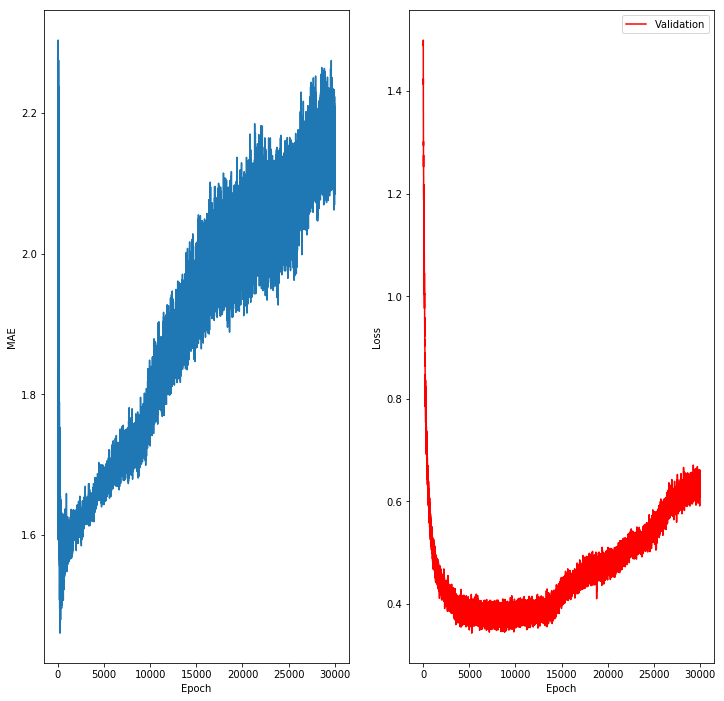

In [5]:
units,layerz,shape, num = 84,3, train_data.shape[1] , 30000
fliked_model_R,history = train(dependent_measures["fliked"],units,layerz,shape,num,split)
plot(history.history)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
minimum Training MAE:  0.3765236084781042
at:  28523
minimum Validation MAE:  1.8145240952328938
at:  424


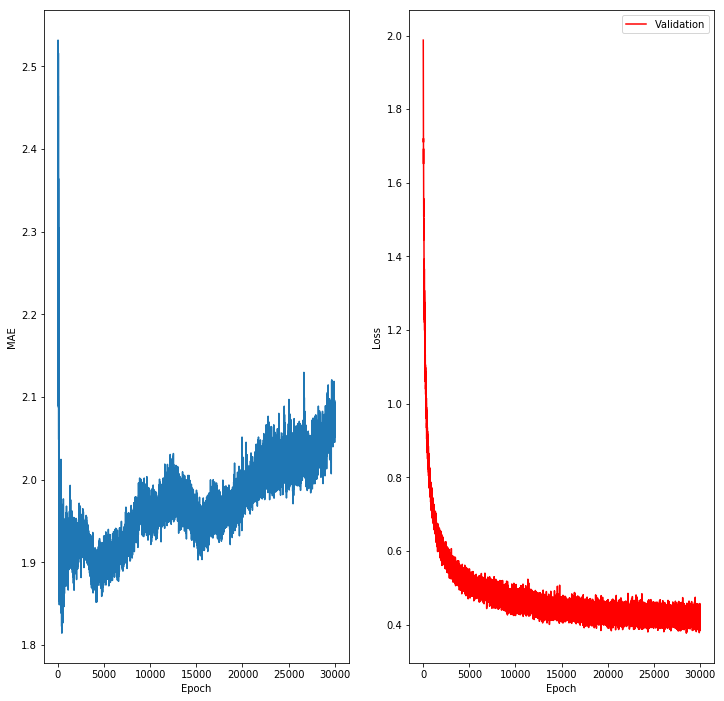

In [5]:
units,layerz,shape,num = 64,5, train_data.shape[1],30000 
flikyes_model_R,flikyes_history  = train(dependent_measures["flikyes"],units,layerz,shape,num,split)

#plot(smooth_points(history.history))
plot(flikyes_history.history)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
minimum Training MAE:  0.32044933972562234
at:  28542
minimum Validation MAE:  1.4101445289646708
at:  275


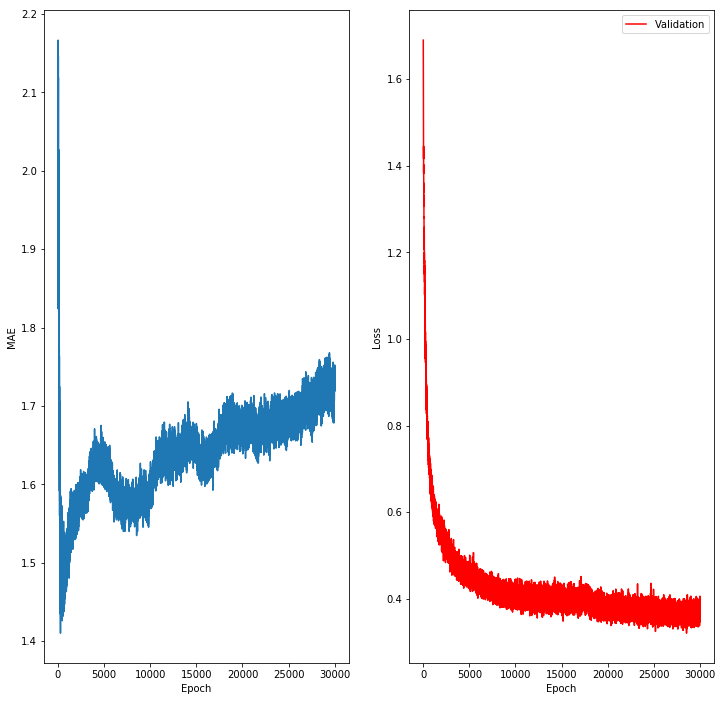

In [5]:
units,layerz,shape,num = 64,5, train_data.shape[1],30000 
fsexatt_model_R,fsexatt_history  = train(dependent_measures["fsexatt"],units,layerz,shape,num,split)

#plot(smooth_points(history.history))
plot(fsexatt_history.history)